# CSC3831 Coursework Part 1: Data Engineering
### Sanjana Muppasani (22029243)


In [3]:
# Loading in standard packages for analysis, feel free to add an extra packages you'd like to use here
import random
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

# Loading in the corrupted dataset to be used in analysis and imputation
hc_path = 'https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/CORRUPTED/HOUSES/houses_0.1_MAR.csv'
houses_corrupted = pd.read_csv(hc_path, header=0)

# Remove an artifact from the dataset
houses_corrupted.drop(["Unnamed: 0"], axis=1, inplace=True)

Above we've loaded in a corrupted version of a housing dataset. The anomalies need to be dealt with and missing values imputed.

### 1. Data Understanding [7]

In [4]:
# peeking at the dataset
houses_corrupted.head()

median_house_value  median_income  housing_median_age  total_rooms  \
0            452600.0         8.3252                41.0        880.0   
1            358500.0         8.3014                21.0       7099.0   
2            352100.0         7.2574                52.0       1467.0   
3            341300.0         5.6431                52.0       1274.0   
4            342200.0         3.8462                52.0       1627.0   

   total_bedrooms  population  households  latitude  longitude  
0           129.0       322.0       126.0     37.88    -122.23  
1          1106.0      2401.0      1138.0     37.86    -122.22  
2           190.0         NaN       177.0     37.85    -122.24  
3           235.0         NaN       219.0     37.85    -122.25  
4           280.0       565.0       259.0     37.85    -122.25

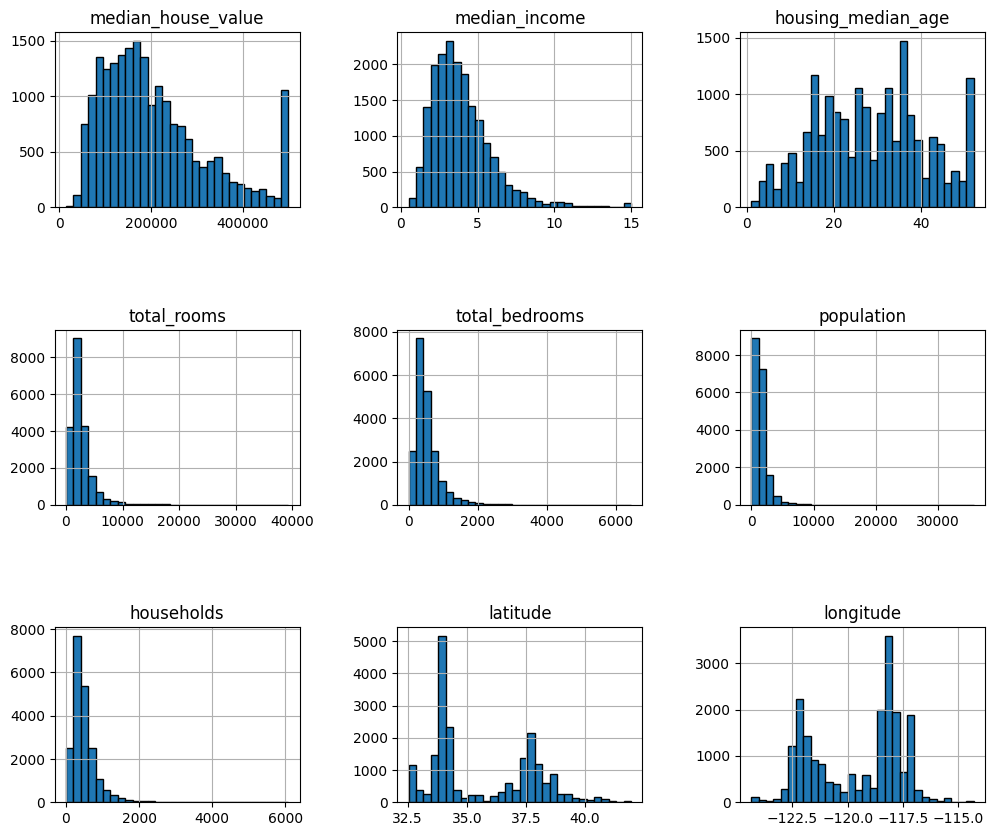

In [5]:
import matplotlib.pyplot as plt

houses_corrupted.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

The histograms reveal that most features in the dataset are significantly right-skewed, characterized by a concentration of data points at lower values and a "long tail" extending toward the right. Features such as total_rooms, total_bedrooms, population, and households exhibit heavy skewness and a wide spread, with median values clustered on the left while extreme outliers stretch the horizontal axis. In terms of centrality, variables like housing_median_age appear more symmetrical and centered around 29 years, yet they still display artificial "spikes" at the far right due to data capping at 52 years. Similarly, median_house_value shows a clear cap at $500,001, which creates a prominent vertical bar at the upper limit of the distribution.

In [6]:
houses_corrupted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_house_value  20640 non-null  float64
 1   median_income       18576 non-null  float64
 2   housing_median_age  18576 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          18576 non-null  float64
 6   households          20640 non-null  float64
 7   latitude            20640 non-null  float64
 8   longitude           20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


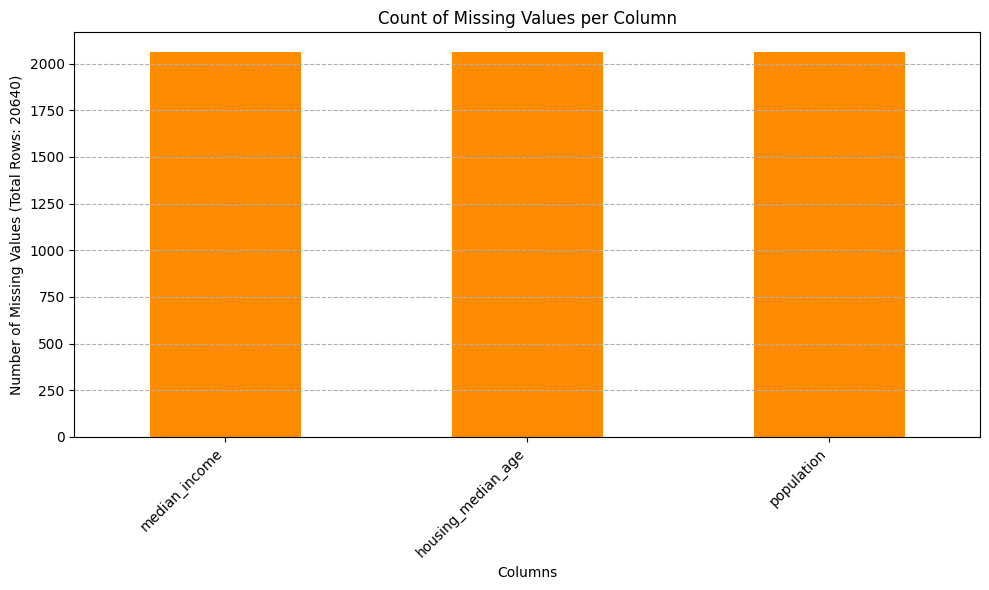

In [7]:
missing_count=houses_corrupted.isnull().sum()
missing_count = missing_count[missing_count>0]
plt.figure(figsize=(10, 6))
missing_count.plot(kind='bar', color='darkorange')
plt.title('Count of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values (Total Rows: 20640)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()

Based on the above results, it can be seen that there are only 3 columns with missing data and all three columns have exactly the same number of missing points. This requires further investigation into the nature of the data that is missing to identify potential patterns or causes for missing data that will help in imputation or any processing. 

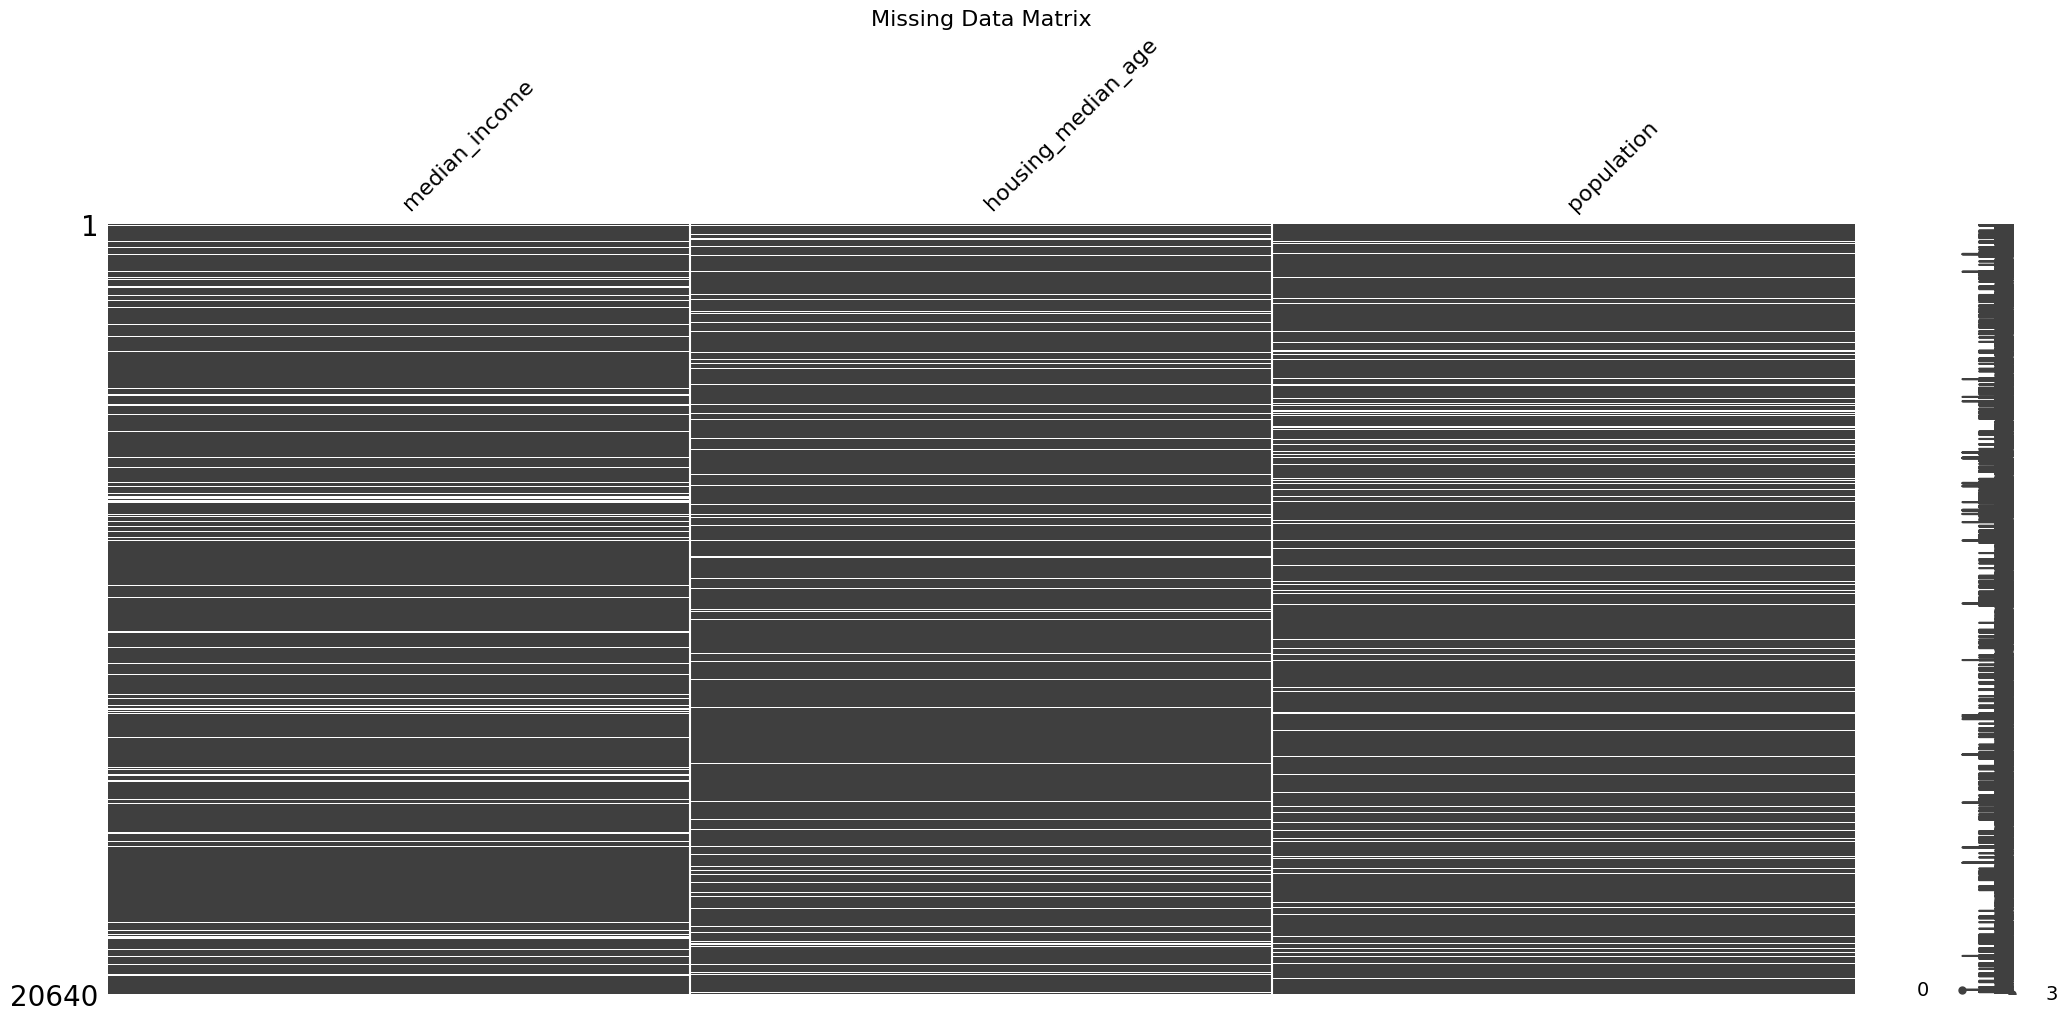

In [8]:
# mapping the missing columns to check if there are any direct correlations in the data that is missing or any direct relationships 
msno.matrix(houses_corrupted[["median_income", "housing_median_age", "population"]])
plt.title('Missing Data Matrix', fontsize=16)
plt.show()


The above missingness matrix helps us visualize the data that is missing across 3 rows, and potentially identiy patterns among them. The white lines represent missing data in a specifc row for that columns. Since there are no stright lines across the 3 columns we can rule out the data being "Missed Not at Random" (MNAR) and potentially "Missing at Random" (MAR). The data seems to be "Missing Completely at Random (MCAR)" 

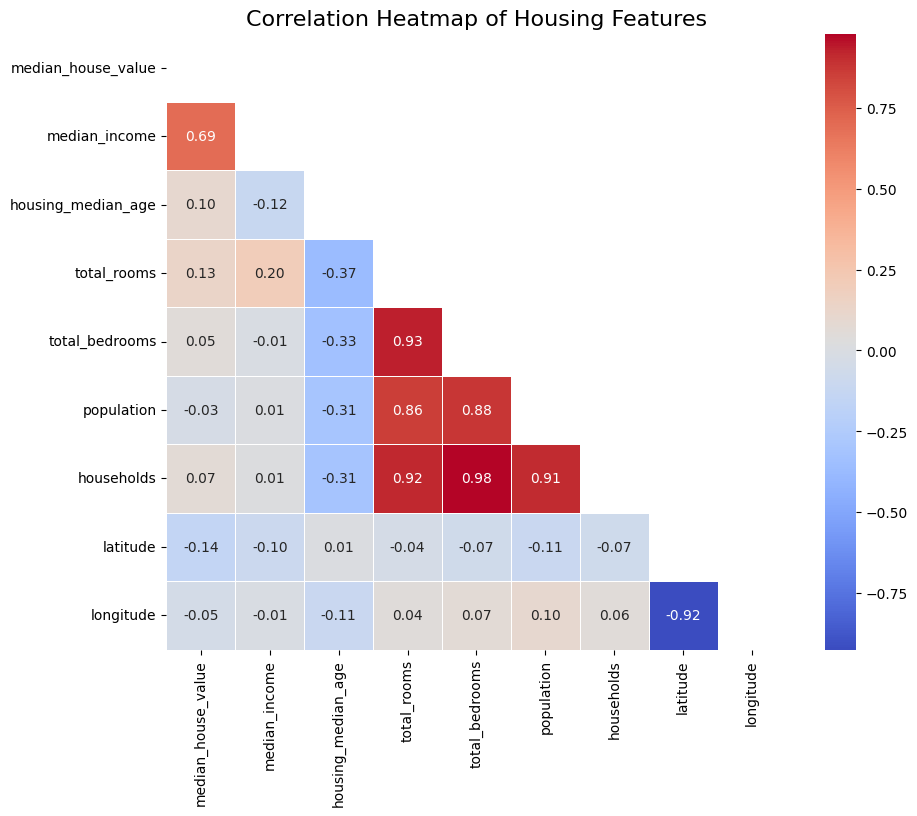

In [9]:

correlation_matrix = houses_corrupted.corr()
plt.figure(figsize=(10, 8))
#for masking the upper half o the triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',  
    mask=mask,
    fmt=".2f",
    linewidths=0.5,
    cbar=True
)
plt.title('Correlation Heatmap of Housing Features', fontsize=16)
plt.show()

For the next step in EDA, the Pearsons Correlation matrix is visualized as a heatmap that allows to gain some understanding of the most important or correlated features of the dataset. High positive values indicate strong positive correlation and high negative values indicate low negative correlation.   

Some of the obvious positive corrlations to note are: Total rooms vs households vs population vs total bedrooms.  
Some of the obvious negative correlations to note are: Latitude and Longitude and median age and total bedrooms (as the number of bedrooms in the house will be greater for families with younger childeren)    

An interesting correlation to note is the median house value and median house income, as the expectation is that median income is a very high positive driver of house value. This might mean that the houseing price might depend on more factors than just the income and this needs to be explored further. For typical machine learning problems, housing price is usually the factor to be determined, therefore let us focus on median house price and factors affecting it. 

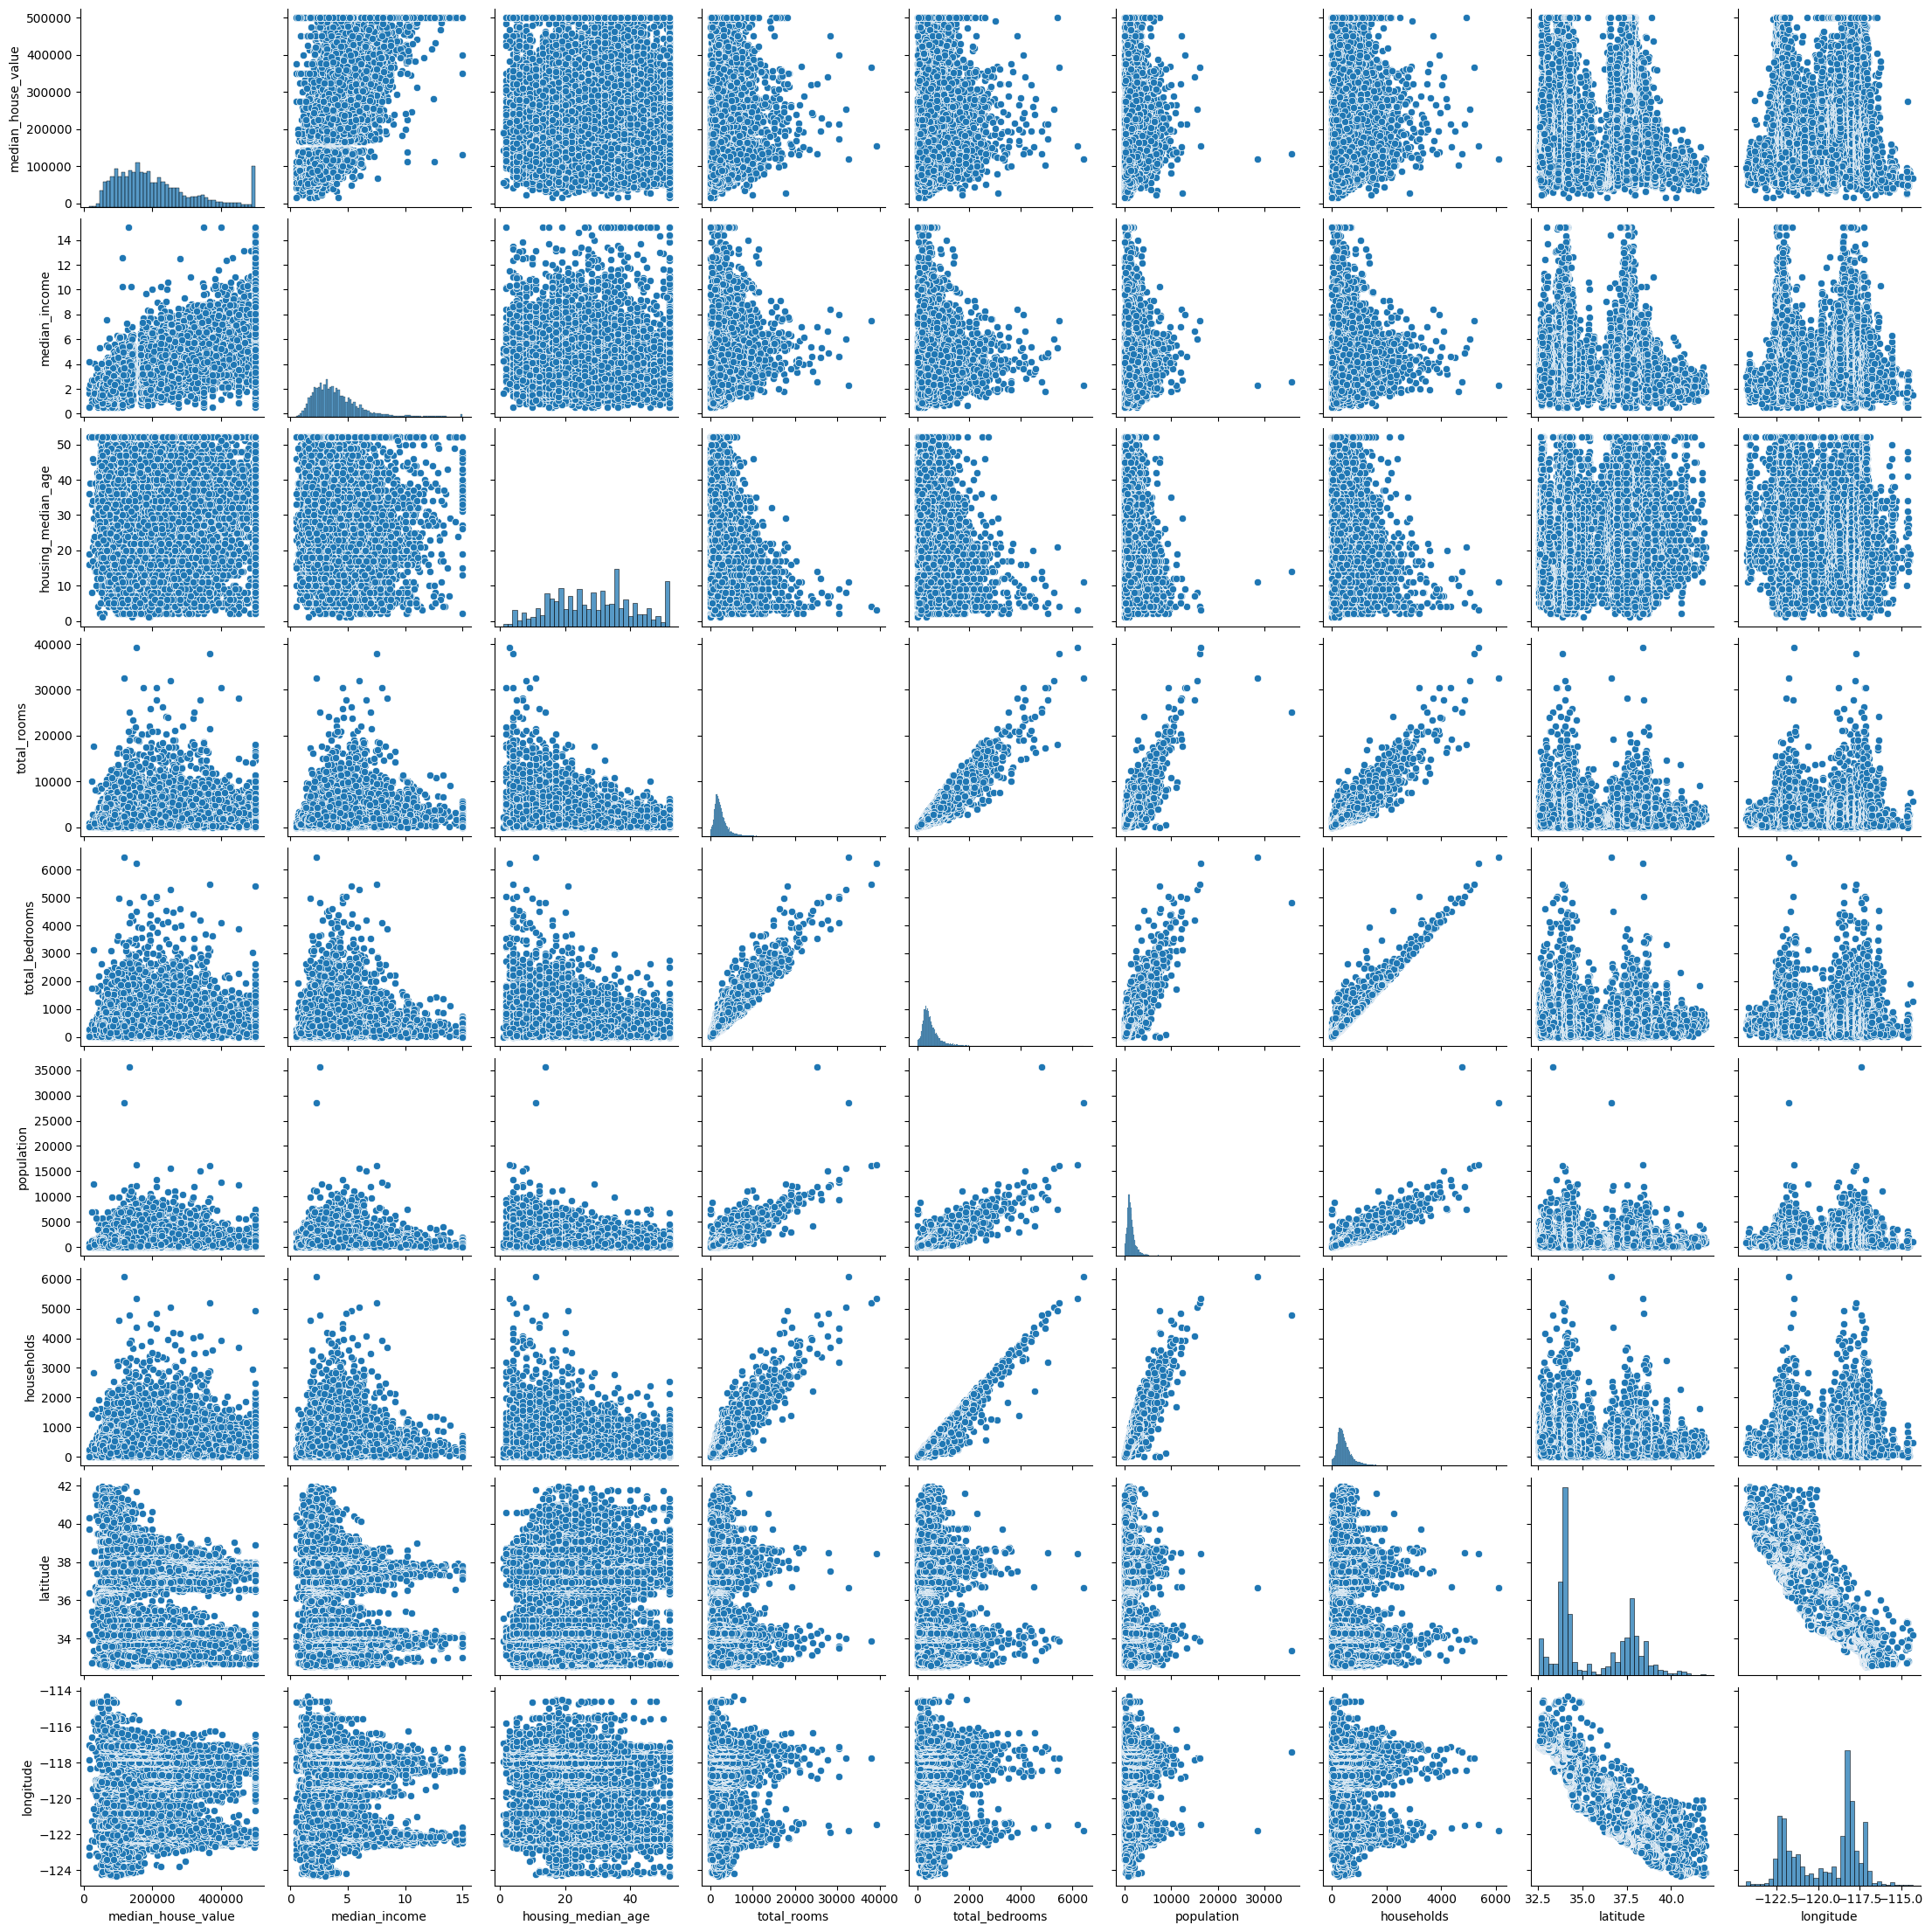

In [10]:
sns.pairplot(houses_corrupted)

Extended Observations from the Pairplot  
Very obvious strong positive correlations can be observed with some of the above pair plots:

**total_bedrooms vs total_rooms:** As the number of bedrooms increases, the total number of rooms increases; the vice versa is very likely. This suggests high collinearity between these two features.  

**population vs households:** As the number of people increases, the number of households increases and vice versa.  

**households vs total_rooms / total_bedrooms:** Similar to the population metric, there is a very tight linear relationship here, as more living units naturally contain more total rooms.  

We can also see some relations with possible outliers and data artifacts; let us have a closer examination:  

**Plot population vs households, population vs total_rooms**  
While these plots show a strong linear trend, there are several points that stray far from the main "cluster" (visible in the middle-right of the matrix).   

**Outliers:** Some districts have a massive population but a relatively low number of households, or vice versa. These could represent unique living situations like large dormitories, barracks, or data entry errors.    

The Median House Value and Median Income seem to have some caps and outliers, lets explore them in detail 

Text(0, 0.5, 'Median income (x10k USD)')

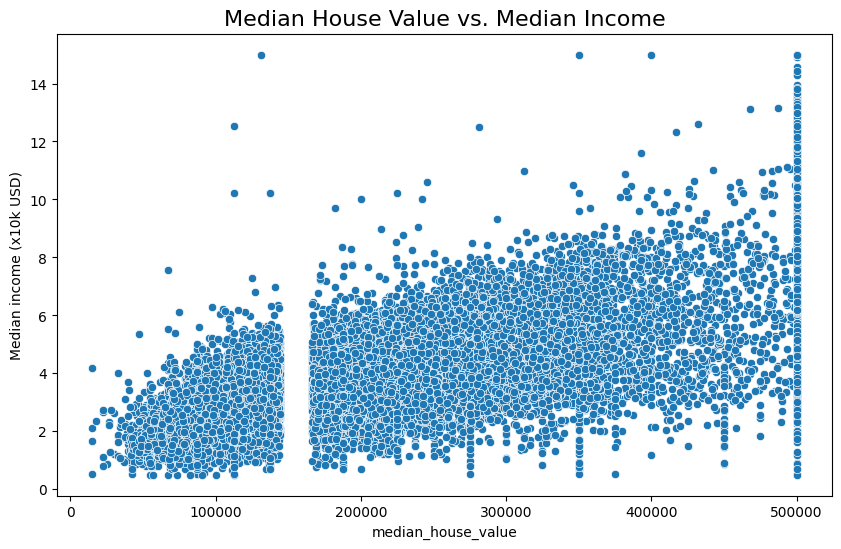

In [11]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=houses_corrupted, x='median_house_value', y='median_income')
plt.title('Median House Value vs. Median Income', fontsize=16)
plt.ylabel('Median income (x10k USD)')

Since the correlation is not as strong as expected, the Median house value vs median income is plotted to have a closer look.  Trends or patterns identified  
1. The max median house value is capped at 500000 USD: there is a hard cap at $500,000, visible as a dense horizontal line at the top of the scatter plot. This is a "ceiling effect" that can bias machine learning models, as they will struggle to predict values above this limit.    

2. There is a "gap" on the x-axis around the 150,000 USD mark where the median income was rounded off to a lower value. This is unsual in a real life setting and can effect the models predictive performance. Notice the faint horizontal lines at roughly $450,000, $350,000, and $280,000. These suggest that some respondents or districts rounded their values to the nearest "big number," which introduces noise into the dataset.  

3. There is a positive linear correlation identified with these variables and when generalized can be said that as the median income increases, the price of the houses increase as well

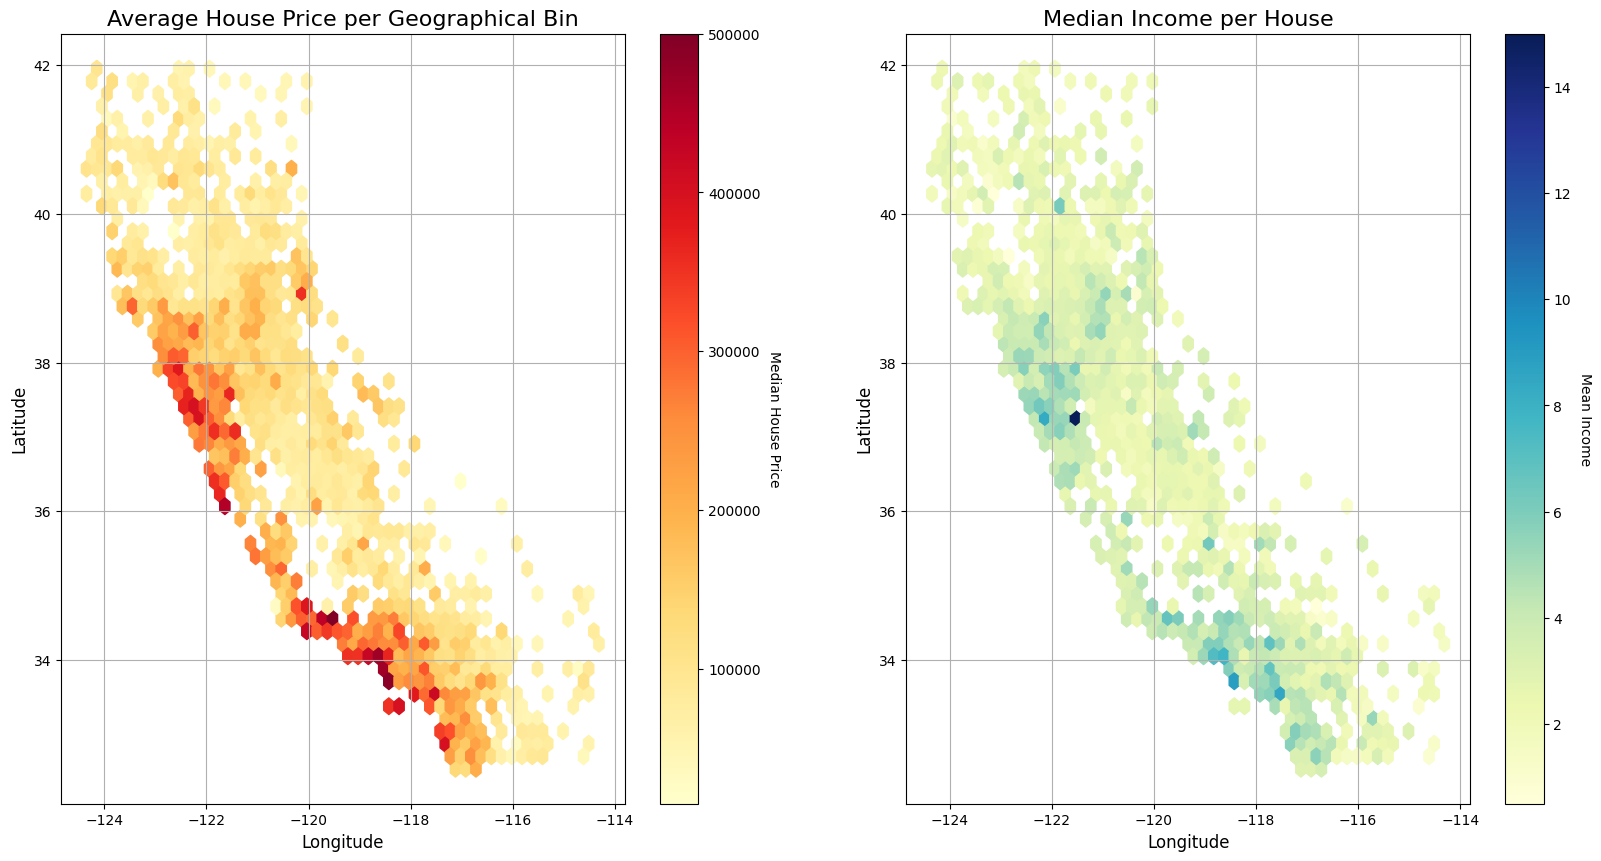

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10)) # 1 row, 2 columns

# --- First Plot: Average House Price (Hexbin) ---
ax1 = axes[0]
hb1 = ax1.hexbin(
    x=houses_corrupted['longitude'],
    y=houses_corrupted['latitude'],
    C=houses_corrupted['median_house_value'],
    gridsize=50,
    cmap=plt.get_cmap("YlOrRd"), # Yellow-Orange-Red
    reduce_C_function=np.mean
)

# Set title and labels for the first plot
ax1.set_title("Average House Price per Geographical Bin", fontsize=16)
ax1.set_xlabel("Longitude", fontsize=12)
ax1.set_ylabel("Latitude", fontsize=12)
ax1.grid(True)

# Add color bar for the first plot
cbar1 = fig.colorbar(hb1, ax=ax1)
cbar1.set_label('Median House Price', rotation=270, labelpad=15)

# --- Second Plot: Mean Income (Hexbin) ---
ax2 = axes[1]
hb2 = ax2.hexbin(
    x=houses_corrupted['longitude'],
    y=houses_corrupted['latitude'],
    C=houses_corrupted['median_income'],
    gridsize=50,
    cmap=plt.get_cmap("YlGnBu"), # Yellow-Green-Blue for distinction
    reduce_C_function=np.mean
)

# Set title and labels for the second plot
ax2.set_title("Median Income per House", fontsize=16)
ax2.set_xlabel("Longitude", fontsize=12)
ax2.set_ylabel("Latitude", fontsize=12) 
ax2.grid(True)

# Add color bar for the second plot
cbar2 = fig.colorbar(hb2, ax=ax2)
cbar2.set_label('Mean Income', rotation=270, labelpad=15)



To further explore possible reasons for lower than expected coorelation between house price and income, geomaps of the location have been built. The latiture and longitude dimensions have been taken to recreate the map of the State of California. 

Mathematically, the above graphs show a non uniform distribution where both the house price and median income are not uniformly distributed across the state, however the trends are more geographic. 

The houses along the west coast of california have a higher average price compared to the houses away from the coast (higher price might be due to proximity to water bodies that give a cooling effect and provide great views)

Upon visual examination of the California state map, the median income per house increases in the west-coast, the areas with the a higher concentration of blue spots (near (-118,34) and (-120,37)) these areas ara Los Angeles (LA) and Sacremento both of which are very prominent areas for celebrities and hosting the state capital respectively.

The above examination of the dataset shows interesting correlations in terms of location in the california state to different metrics, lets examine other metrics such as population and household density in these areas 

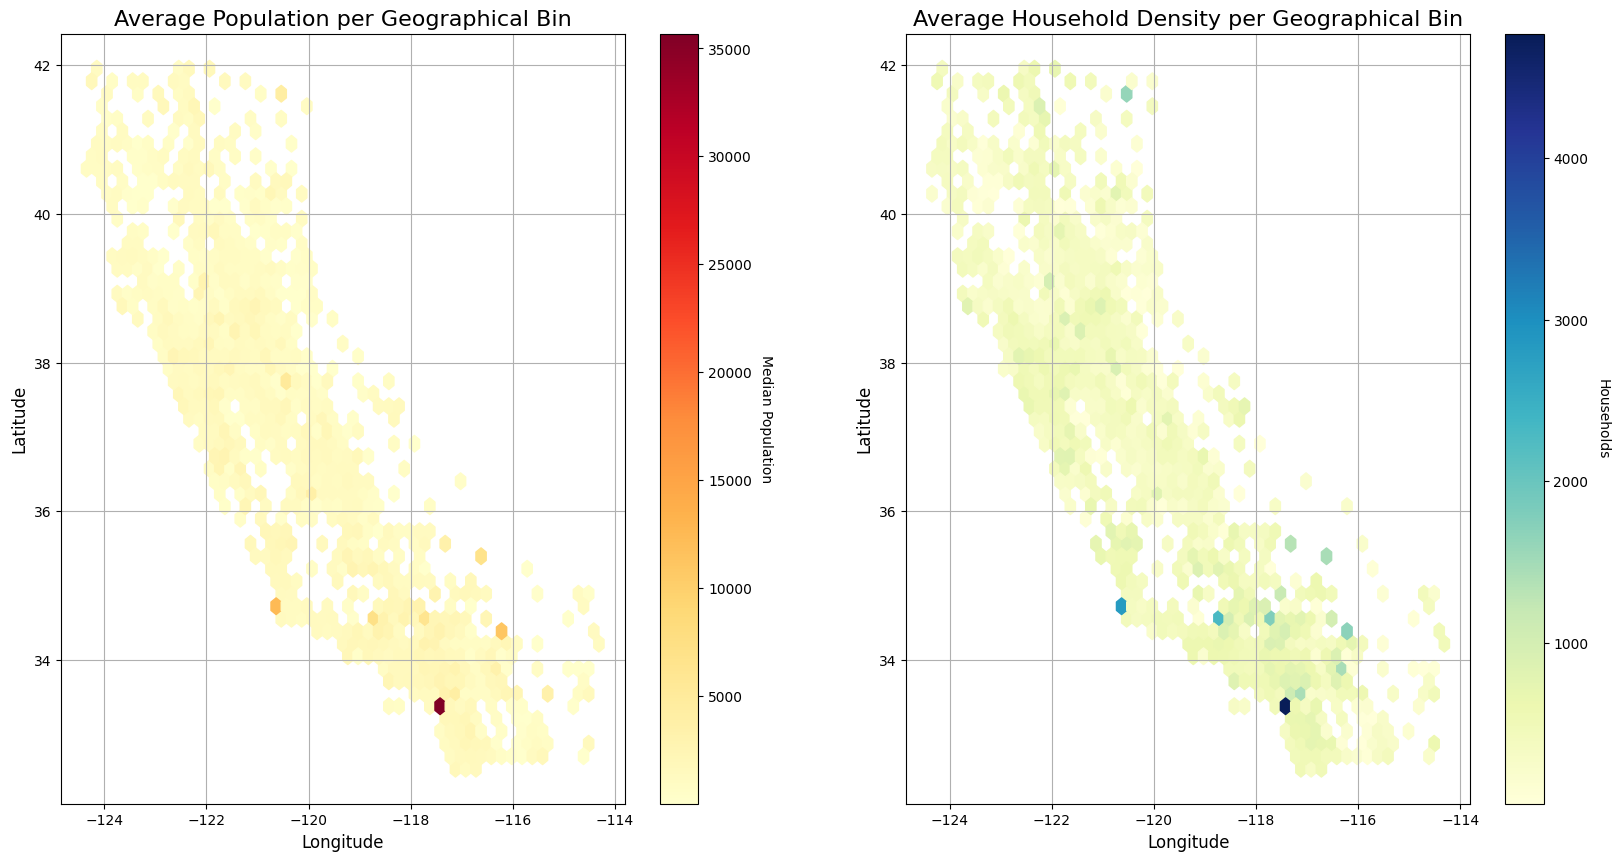

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10)) 


ax1 = axes[0]
hb1 = ax1.hexbin(
    x=houses_corrupted['longitude'],
    y=houses_corrupted['latitude'],
    C=houses_corrupted['population'],
    gridsize=50,
    cmap=plt.get_cmap("YlOrRd"), 
    reduce_C_function=np.mean
)

ax1.set_title("Average Population per Geographical Bin", fontsize=16)
ax1.set_xlabel("Longitude", fontsize=12)
ax1.set_ylabel("Latitude", fontsize=12)
ax1.grid(True)

cbar1 = fig.colorbar(hb1, ax=ax1)
cbar1.set_label('Median Population', rotation=270, labelpad=15)

ax2 = axes[1]
hb2 = ax2.hexbin(
    x=houses_corrupted['longitude'],
    y=houses_corrupted['latitude'],
    C=houses_corrupted['households'],
    gridsize=50,
    cmap=plt.get_cmap("YlGnBu"), 
)


ax2.set_title("Average Household Density per Geographical Bin", fontsize=16)
ax2.set_xlabel("Longitude", fontsize=12)
ax2.set_ylabel("Latitude", fontsize=12) 
ax2.grid(True)


cbar2 = fig.colorbar(hb2, ax=ax2)
cbar2.set_label('Households', rotation=270, labelpad=15)

Despite the differances in the scales for both the graphs, there is a very obvious in the population and housing desnity in Los Angeles. The population distribution and the number of households across the state is almost uniform however shows a clear outlier near the LA region.  

Both the above sets of graphs show another interesting feature, while the density of the red dots are hihger near the LA region of the map, this is not propotionate to the income of this region (observed due to the lack of density of dark blue circles in that region) which further strengthens the argument that house price is not solely dependant on the median income however is greatly influnced by geographical regions such as (proximity to the coast, population density, housing supply demand)

**Summary**

**Feature Skew and Centrality:** Most features, particularly total_rooms, total_bedrooms, population, and households, are heavily right-skewed with long tails extending toward extreme outliers. In contrast, housing_median_age is more symmetrical, centered around 29 years, though it remains impacted by artificial spikes.

**Median Income Trends:** While median_income is the primary positive driver for house prices, it exhibits a non-uniform distribution with a notable gap around the $150,000 mark, suggesting data rounding or regional reporting thresholds.

**Capping and Artifacts:** A significant "ceiling effect" is visible where median_house_value is capped at $500,001, appearing as a dense horizontal line that may bias predictive modeling.

**Geographic Outliers:** Geographic mapping reveals that high house values are concentrated along the west coast and in dense hubs like Los Angeles, where population and household density act as significant outliers compared to the rest of the state.

### 2. Outlier Identification [10]
1. Utilise a statistical outlier detection approach (i.e., **no** KNN, LOF, 1Class SVM)
2. Utilise an algorithmic outlier detection method of your choice
3.  Compare results and decide what to do with identified outliers
  - Include graphs, statistics, and written descriptions as appropriate
4.  Explain what you are doing, and why your analysis is appropriate
5. Comment on benefits/detriments of statistical and algorithmic outlier detection approaches


In [14]:
houses_corrupted.describe(include='all')

median_house_value  median_income  housing_median_age   total_rooms  \
count        20640.000000   18576.000000        18576.000000  20640.000000   
mean        206855.816909       3.929958           28.324182   2635.763081   
std         115395.615874       1.964296           12.584914   2181.615252   
min          14999.000000       0.499900            1.000000      2.000000   
25%         119600.000000       2.560300           18.000000   1447.750000   
50%         179700.000000       3.572400           28.000000   2127.000000   
75%         264725.000000       4.870050           37.000000   3148.000000   
max         500001.000000      15.000100           52.000000  39320.000000   

       total_bedrooms    population    households      latitude     longitude  
count    20640.000000  18576.000000  20640.000000  20640.000000  20640.000000  
mean       537.898014   1488.069283    499.539680     35.631861   -119.569704  
std        421.247906   1170.585810    382.329753      2.135952      2.003532  
min          1.000000      3.000000      1.000000     32.540000   -124.350000  
25%        295.000000    839.000000    280.000000     33.930000   -121.800000  
50%        435.000000   1227.000000    409.000000     34.260000   -118.490000  
75%        647.000000   1803.000000    605.000000     37.710000   -118.010000  
max       6445.000000  35682.000000   6082.000000     41.950000   -114.310000

Based on the above table that gives information about the statistical features of the dataset like the 75% percentile, min max values and std, here are some observations:  

**Extreme Right-Tail Outliers:** Features such as total_rooms, total_bedrooms, population, and households show extreme discrepancies between their 75th percentiles and their maximum values. For example, the maximum population (35,682) is nearly 20 times higher than its 75th percentile (1,803), indicating the presence of high-density outlier districts.

**Income Extremes:** The maximum median_income of 15.0001 is more than triple the 75th percentile (4.87005), highlighting a small number of districts with exceptionally high wealth relative to the rest of the state.  

**Room and Bedroom Scaling:** The massive spreads in total_rooms (max 39,320 vs. median 2,127) and total_bedrooms (max 6,445 vs. median 435) suggest that while most districts contain a few thousand rooms, some unique districts or data entries represent massive developments or recording anomalies.

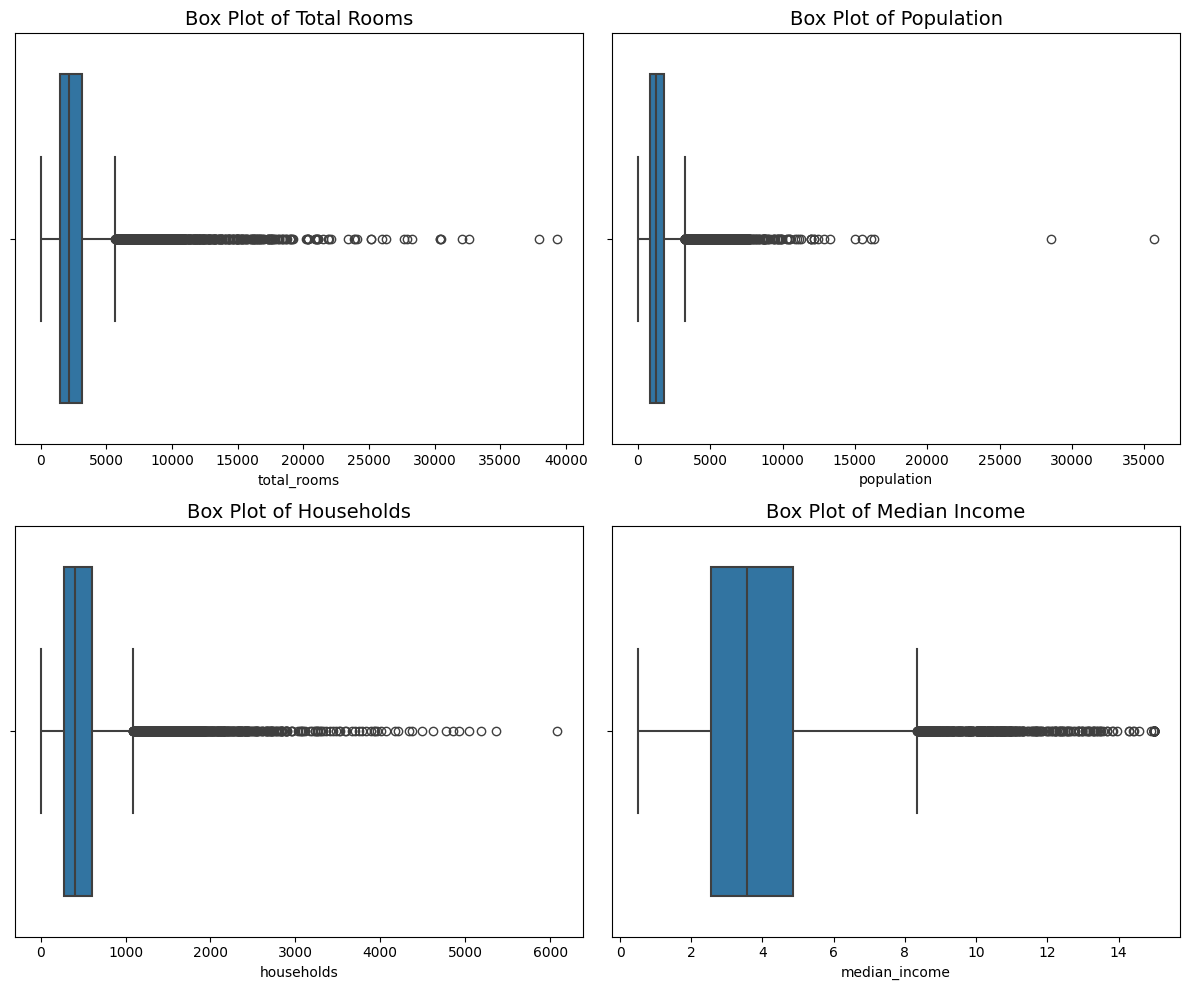

In [15]:
high_skew = ["total_rooms", "population", "households", "median_income"]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(high_skew):
    sns.boxplot(x=houses_corrupted[col], ax=axes[i], linewidth=1.5)
    axes[i].set_title(f'Box Plot of {col.replace("_", " ").title()}', fontsize=14)

plt.tight_layout()
plt.show()

The above boxplots visualizes the data with high skew to identify the appropriate methods for outlier detection. 

Households and Total rooms for the California housing dataset are block attributes and therefore the number of household and total rooms cannot be considered outliers without further modification, Since the measurement is made for blocks of geographical locations whose sizes vary, the attributes cannot be capped or dismissed as outliers. 

median_income and Population on the other hand can be considered for outlier detection. As explored in the EDA, median_income is strongly correlated to median_house_value, outliers for this attribute can distort any linear model's ability to make an accurate prediction about the median_house_value.

To analyse linear outliers (outliers for a specific columns) I have selected Inter Quartile Range (IQR) method. The columns median income and population are heavily skewed to the right. The IQR method is non-parametric and uses the median, making it highly robust to this skewness and the influence of extreme values and therefore is chosen for statistical outlier detection 

In [16]:
cap_attributes = ["median_income", "population"]

houses_corrupted['is_iqr_capped'] = False

for attribute in cap_attributes:
    Q1 = houses_corrupted[attribute].quantile(0.25)
    Q3 = houses_corrupted[attribute].quantile(0.75)
    IQR = Q3 - Q1

    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    outliers_iqr_mask = (houses_corrupted[attribute] < lower_limit) | (houses_corrupted[attribute] > upper_limit)
    outlier_count = outliers_iqr_mask.sum()

    houses_corrupted.loc[outliers_iqr_mask, 'is_iqr_capped'] = True

    houses_corrupted[attribute] = np.where(houses_corrupted[attribute] > upper_limit, upper_limit, houses_corrupted[attribute])
    houses_corrupted[attribute] = np.where(houses_corrupted[attribute] < lower_limit, lower_limit, houses_corrupted[attribute])
    
    print(f"IQR Analysis for {attribute}:")
    print(f"  Outliers Identified (pre-cap): {outlier_count}")
    print(f"  Upper Limit (Capped Value): {upper_limit:.2f}")

total_iqr_capped_rows = houses_corrupted['is_iqr_capped'].sum()
print(f"\nTotal UNIQUE rows where at least one feature was IQR-Capped: {total_iqr_capped_rows}")
print("-" * 50)

IQR Analysis for median_income:
  Outliers Identified (pre-cap): 562
  Upper Limit (Capped Value): 8.33
IQR Analysis for population:
  Outliers Identified (pre-cap): 1077
  Upper Limit (Capped Value): 3249.00

Total UNIQUE rows where at least one feature was IQR-Capped: 1616
--------------------------------------------------


In this stage, the IQR (Inter-Quartile Range) method was used as a robust statistical tool to "tame" the extreme univariate outliers in the median_income and population features. By calculating the spread between the 25th and 75th percentiles, upper and lower "fences" were established at 1.5 x IQR beyond the quartiles to define the boundaries of normal data.  
Rather than deleting these observations, a technique called Winsorizing was applied: any value exceeding the upper limit was capped at that maximum threshold. The results show that 1,616 unique rows were modified, effectively reducing the heavy right-skewness of the dataset. This process stabilizes the variance and ensures that extreme values do not disproportionately bias the subsequent processes. 

Isolation Forest (IF)  on the other hand is a multi-dimensional outlier detection method. While IQR focuses on the values in a single column, IF captures nuances in the relation between multiple attributes and detects outliers based on that.  
The Isolation Forest was applied to the eight numerical features, operating on the principle that anomalies are "few and different," the algorithm used random partitioning to isolate data points; those isolated with significantly fewer splits were flagged as outliers. This algorithm builds on the work done by IQR ("windsoring" data to remove caps) and then using this data with IF to ensure the linear outliers do not effect the models capability to identify multi-dimensional outliers. 

In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler

numerical_features = houses_corrupted.columns.tolist() 
if 'median_house_value' in numerical_features:
    numerical_features.remove('median_house_value') 

X = houses_corrupted[numerical_features].copy() 

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

contamination_rate = 0.02 # Flag 2% of the data as anomalies
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=contamination_rate,
    random_state=42,
    n_jobs=-1
)

outlier_predictions = iso_forest.fit_predict(X_scaled_df)
houses_corrupted['is_outlier_iso_forest'] = outlier_predictions

num_if_outliers = (outlier_predictions == -1).sum()
print(f"Isolation Forest Analysis:")
print(f"  Total rows flagged as multivariate outliers (to be removed): {num_if_outliers}")
print(f"  Percentage Flagged: {num_if_outliers / len(houses_corrupted) * 100:.2f}%")
print("-" * 50)

Isolation Forest Analysis:
  Total rows flagged as multivariate outliers (to be removed): 413
  Percentage Flagged: 2.00%
--------------------------------------------------


Isolation Forest successfully identified 413 rows (2.00%) as multivariate outliers. This means these data points were not necessarily extreme in just one dimension, but were "isolated" due to an unusual or rare combination of all eight features. For example, a district might have an average income but a bizarrely high room-to-household ratio in a specific geographic coordinate that makes it an anomaly.

In [18]:
overlap_count = houses_corrupted[(houses_corrupted['is_iqr_capped'] == True) & (houses_corrupted['is_outlier_iso_forest'] == -1)].shape[0]

print("Comparison Analysis:")
print(f"  Rows flagged by BOTH methods: {overlap_count}")
print(f"  Rows flagged ONLY by Isolation Forest: {num_if_outliers - overlap_count}")

Comparison Analysis:
  Rows flagged by BOTH methods: 403
  Rows flagged ONLY by Isolation Forest: 10


Then the performance of both models was compared to see the overlap in the number of points, this information can be used for making a decision when dropping data. 

In [19]:
houses_corrupted['anomaly_score'] = iso_forest.decision_function(X_scaled_df)
if_outliers_df = houses_corrupted[houses_corrupted['is_outlier_iso_forest'] == -1].sort_values(
    by='anomaly_score', 
    ascending=True
).head()
print("\n--- Decision: Characteristics of the Strongest IF Outliers (Rows to Remove) ---")
print(if_outliers_df[['median_income', 'latitude', 'longitude', 'median_house_value']])


--- Decision: Characteristics of the Strongest IF Outliers (Rows to Remove) ---
       median_income  latitude  longitude  median_house_value
13139            NaN     38.43    -121.44            153700.0
15459         4.6357     33.15    -117.27            244900.0
15413         4.1405     33.23    -117.27            198500.0
9880          2.3087     36.64    -121.79            118800.0
12215         4.5841     33.52    -117.12            212300.0


This final step moves beyond simple filtering to perform a "sanity check" on the most extreme anomalies detected by the algorithm. By extracting the anomaly scores (calculated via the Isolation Forest’s decision function), we can rank the flagged data points by their degree of isolation—effectively identifying which rows the model found most suspicious.

The goal here is qualitative validation: by inspecting the specific feature combinations of these top-ranked outliers (such as mismatched income levels relative to geographic location or home value), we can verify that they represent genuine errors or rare, high-leverage anomalies rather than valid data. This targeted inspection provides the ultimate justification for dropping these records, ensuring the final regression model is built on a clean, representative foundation that hasn't been skewed by multivariate noise.

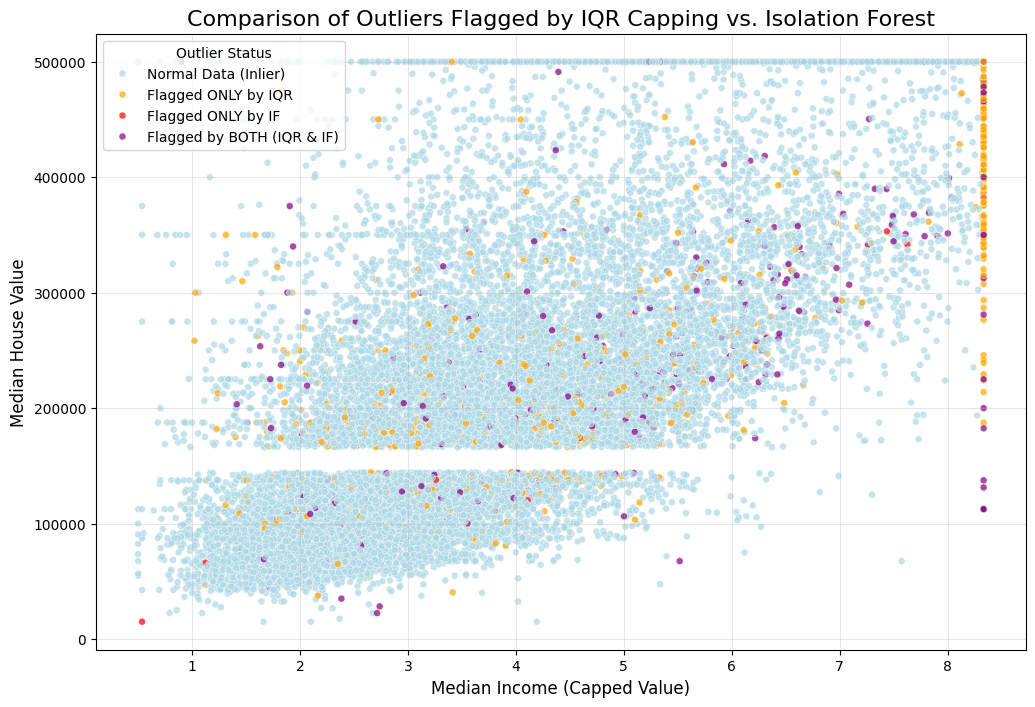


Final dataset size after removing 413 Isolation Forest outliers: 20227


In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np # Needed for any potential re-load or utility functions


plot_data = houses_corrupted.copy() 
def create_category(row):
    if row['is_outlier_iso_forest'] == -1 and row['is_iqr_capped']:
        return 'Flagged by BOTH (IQR & IF)'
    elif row['is_outlier_iso_forest'] == -1:
        return 'Flagged ONLY by IF'
    elif row['is_iqr_capped']:
        return 'Flagged ONLY by IQR'
    else:
        return 'Normal Data (Inlier)'

houses_corrupted['Outlier_Category'] = houses_corrupted.apply(create_category, axis=1)

category_order = ['Normal Data (Inlier)', 'Flagged ONLY by IQR', 'Flagged ONLY by IF', 'Flagged by BOTH (IQR & IF)']
color_palette = {'Normal Data (Inlier)': 'lightblue', 'Flagged ONLY by IQR': 'orange', 'Flagged ONLY by IF': 'red', 'Flagged by BOTH (IQR & IF)': 'purple'}

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=houses_corrupted,
    x='median_income', 
    y='median_house_value',
    hue='Outlier_Category', 
    hue_order=category_order,
    palette=color_palette,
    alpha=0.7,
    s=25
)
plt.title('Comparison of Outliers Flagged by IQR Capping vs. Isolation Forest', fontsize=16)
plt.xlabel('Median Income (Capped Value)', fontsize=12) 
plt.ylabel('Median House Value', fontsize=12)
plt.legend(title='Outlier Status', loc='upper left')
plt.grid(True, alpha=0.3)
plt.show() # 

# C. Final Cleaning Decision (Removing IF outliers)
# Decision: Retain the IQR-capped values, but remove the rows flagged by Isolation Forest.
houses_final_clean = houses_corrupted[houses_corrupted['is_outlier_iso_forest'] == 1].drop(
    columns=['is_iqr_capped', 'is_outlier_iso_forest', 'anomaly_score', 'Outlier_Category']
)

print(f"\nFinal dataset size after removing {num_if_outliers} Isolation Forest outliers: {len(houses_final_clean)}")

Here is a visualization that highlights the points that have been flagged as outliers/anomalies by both the methods. This visualization is a critical component of the analysis because it maps the multidimensional findings of the Isolation Forest onto the unidimensional limits of the IQR method.  

1. The vertical orange band on the far right (at approximately 8.33) represents the success of the Winsorization process. Every data point that originally exceeded the statistical upper limit for income has been pulled back to this "fence." This tames the variance of the primary predictor without losing data volume.  

2. The red dots scattered throughout the center of the main blue cluster are perhaps the most important finding. These points look perfectly "normal" in terms of income and house value, yet the Isolation Forest flagged them because their combination of other features (like unusual occupancy rates or geographic coordinates) made them isolated in the 8D space.  

3. The purple dots represent the most unambiguous outliers—rows that were extreme enough to be capped by IQR and isolated by the algorithm. Removing these rows is essential for model stability, as these high-leverage points would otherwise disproportionately "pull" the regression line away from the true trend.


**Summary of the Outlier Detection Algorithms**  

1. Statistical Approach: IQR CappingTo address extreme right-skewness in median_income and population, a non-parametric Interquartile Range (IQR) method was used.

Methodology: Upper and lower boundaries were set at 1.5 x IQR beyond the quartiles to define the range of "normal" data. 

Action: Rather than dropping data, Winsorization (capping) was applied to 1,616 unique rows.

Appropriateness: This method is highly robust to skewness. It stabilizes variance and prevents univariate extremes from biasing the subsequent scaling process.

Trade-offs: While efficient at taming individual features, it cannot detect multivariate anomalies where the relationship between features is the issue.
______________________________________________________________________________________________

2. Algorithmic Approach: Isolation Forest (IF)  
An Isolation Forest was selected to identify complex, multi-dimensional anomalies that univariate methods miss.

Methodology: This algorithm isolates points by random partitioning; anomalies are flagged because they require fewer "splits" to separate from the bulk of the data.

Results: The IF identified 413 rows (2.00%) as multivariate outliers.

Appropriateness: It captures "hidden" noise—such as districts with average income but impossible occupancy rates—that would otherwise destabilize a regression model.

Trade-offs: It is powerful for finding contextual anomalies but requires careful feature scaling (e.g., RobustScaler) to perform accurately.

______________________________________________________________________________________________
3. The final cleaning strategy utilized both methods to ensure a representative dataset:

Comparison: An overlap analysis and "sanity check" of anomaly scores were used to rank the most isolated points.

Final Action: I chose to retain the capped values from the IQR process (to preserve data volume) but drop the 413 rows flagged by the Isolation Forest.

Rationale: This sequential approach is the most robust; the IQR stabilizes the feature space, while the IF surgically removes high-leverage multivariate noise that would otherwise bias predictive accuracy.

### 3. Imputation [10]
- Identify which features should be imputed and which should be removed
  - Provide a written rationale for this decision
- Impute the missing records using KNN imputation
- Impute the missing records using MICE imputation
- Compare both imputed datasets feature distributions against each other and the non-imputed data
- Build a regressor on all thre datasets
  - Use regression models to predict house median price
  - Compare regressors of non-imputed data against imputed datas
  - **Note**: If you're struggling to compare against the original dataset focus on comparing the two imputed datasets against each other


In [30]:
missing_stats = pd.DataFrame({
    'Missing Count': houses_corrupted.isnull().sum(),
    'Percentage (%)': (houses_corrupted.isnull().mean() * 100).round(2)
})
missing_only = missing_stats[missing_stats['Missing Count'] > 0]
print("Columns with Missing Data:")
print(missing_only)

Columns with Missing Data:
                    Missing Count  Percentage (%)
median_income                2064            10.0
housing_median_age           2064            10.0
population                   2064            10.0


While housing_median_age and population show low linear correlation with price (as given in the Persons heatmap in EDA), dropping them would sacrifice over 2,000 observations and critical context. Population is essential for deriving density ratios like occupancy, and housing_median_age provides structural data that non-linear models can utilize.

With missingness limited to 10%, imputation is a safer strategy than deletion to prevent model bias. Using KNN and MICE allows us to fill these gaps by leveraging local similarities or iterative regressions, preserving the dataset's integrity for the final predictive model.

In [35]:
houses_final_clean.head()

median_house_value  median_income  housing_median_age  total_rooms  \
0            452600.0         8.3252                41.0        880.0   
1            358500.0         8.3014                21.0       7099.0   
2            352100.0         7.2574                52.0       1467.0   
3            341300.0         5.6431                52.0       1274.0   
4            342200.0         3.8462                52.0       1627.0   

   total_bedrooms  population  households  latitude  longitude  
0           129.0       322.0       126.0     37.88    -122.23  
1          1106.0      2401.0      1138.0     37.86    -122.22  
2           190.0         NaN       177.0     37.85    -122.24  
3           235.0         NaN       219.0     37.85    -122.25  
4           280.0       565.0       259.0     37.85    -122.25

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.impute import IterativeImputer

cols_to_impute = ['median_income', 'housing_median_age', 'population']

df_knn = houses_final_clean.copy()
df_mice = houses_final_clean.copy()

knn_imputer = KNNImputer(n_neighbors=5)
df_knn[cols_to_impute] = knn_imputer.fit_transform(df_knn[cols_to_impute])

mice_imputer = IterativeImputer(random_state=42, max_iter=10)
df_mice[cols_to_impute] = mice_imputer.fit_transform(df_mice[cols_to_impute])

In [41]:
# Use this dataset for comparison against the imputed datasets
h_path = 'https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/TARGET-DATASETS/ORIGINAL/houses.csv'
houses = pd.read_csv(h_path, header=0)

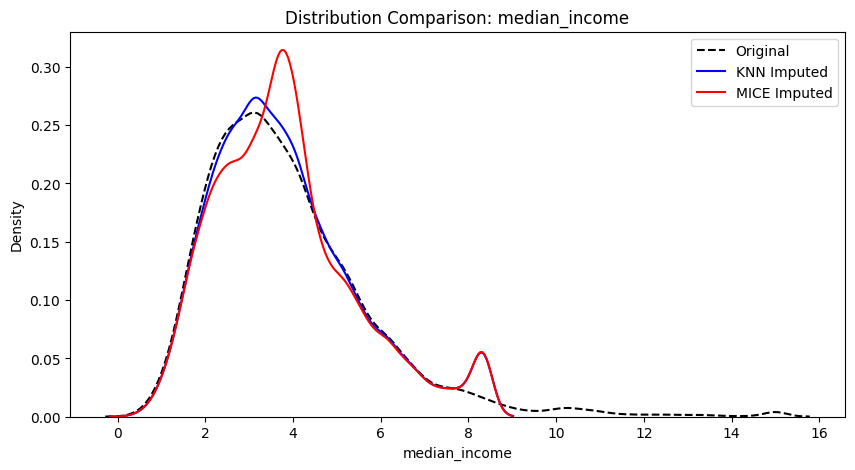

In [45]:
def plot_distributions(feature_name):
    plt.figure(figsize=(10, 5))
    sns.kdeplot(houses[feature_name], label='Original', color='black', linestyle='--')
    sns.kdeplot(df_knn[feature_name], label='KNN Imputed', color='blue')
    sns.kdeplot(df_mice[feature_name], label='MICE Imputed', color='red')
    plt.title(f'Distribution Comparison: {feature_name}')
    plt.legend()
    plt.show()

# Visualize the most important feature
plot_distributions('median_income')

This Kernel Density Estimate (KDE) plot provides a visual comparison of how different imputation methods reconstruct the distribution of the median_income variable compared to the Original data (black). 

The blue line from KNN follows the original distribution's shape very closely. KNN is performing well here because it fills in missing values based on the "average" of similar samples. It preserves the general variance and spread of the data. his is often a "safer" imputation to maintain the overall statistical structure without introducing artificial peaks.

For the MICE imputation on the other hand, significant "spikes" where the red line can be observed where it deviates from the dashed black line, particularly around the values of 4 and 8. Since MICE works by modeling each variable as a function of others. These spikes suggest that the predictive model within MICE is gravitating toward specific predicted values too frequently. It is "over-concentrating" the imputed data into narrow ranges.  

Therefore based entirely on the graph, KNN is the better model as it follows the data closely. 


In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
datasets = {
    "Baseline": houses,
    "KNN Imputed": df_knn,
    "MICE Imputed": df_mice
}

rmse_results = {}

for name, df in datasets.items():
    X = df.drop(columns=['median_house_value'])
    y = df['median_house_value']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)

    preds = rf.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    rmse_results[name] = rmse

print("\n--- Final Model Performance (RMSE) ---")
for method, val in rmse_results.items():
    print(f"{method}: {val:,.2f}")


--- Final Model Performance (RMSE) ---
Baseline: 49,752.82
KNN Imputed: 49,198.94
MICE Imputed: 48,551.05


However the results of the regressor paint a different picture. Since lower values of RMSE indicate better peformance the imputation strategies change significantly: The best model is MICE followed by KNN. 

Both imputation methods improved the model compared to the Baseline. This tells us that even though the imputed values are "guesses," they contain enough signal to help the Random Forest model learn better patterns than it could with the original (likely smaller or less complete) Baseline dataset.

Therefore this introduces a tradeoff- KNN's superiority for statistical soundness vs MICE's higher predictive power. 


Final thoughts: While neither model is clearly better, they both have theie own strenghts based on the context. MICE provided the highest predictive power (lowest RMSE), likely because it successfully captured multivariate relationships, but KNN provided a more "honest" representation of the original data distribution (as seen in the KDE plot).

### 4. Conclusions & Throughts [3]
- Discuss methods used for anomaly detection, pros/cons of each method
- Discuss challenges/difficulties in anomaly detection implementation
- Discuss methods used for imputation, pros/cons of each method
- Discuss challenges/difficulties in imputation implementation

1. Methods for Anomaly Detection  

- Inter-Quartile Range or IQR is used as the statistical anomaly detected method for this task.  This univariate method identifies outliers by calculating the spread between the 25th and 75th percentiles. It defines "normal" data boundaries using lower and upper fences (1.5 x IQR). Winsorization was applied to "tame" extreme values in median_income and population, capping them at the upper fence to reduce skewness.   

- Isolation Forest or IF was used for algorithmic detection for this dataset. This is a multivariate method that detects anomalies by isolating points through random partitioning. It was used to catch "contextual outliers"—points that look normal in one column but have impossible or rare combinations across multiple features.  

2. Challenges and difficulties for Anomaly Detection  

- Selecting an appropriate contamination threshold proved challenging, as the dataset's heavy right-skew made it difficult to distinguish between noise and rare but valid housing data. Without deep domain expertise, it was difficult to determine if extreme values—such as exceptionally high incomes—were recording errors or valid "long-tail" market realities. Deciding whether to cap (Winsorize) or drop observations was a significant hurdle; a sequential strategy was eventually chosen to stabilize variance first, then surgically remove the most isolated multivariate anomalies.  

3. Methods for Imputation  (KNN and MICE)

- K-Nearest Neighbours (KNN) was one of the algorithms used for Imputation. The algorithm looks at k closest points (in this case k=5) and the the shortest distance to other points to determine the missing values in the dataset.

    _Pros:_   It does not make any asumptions about the distribution of data and it excels at capturing local patterns (patterns of the neighbouring values in this case). This allows it to reconstruct data similar to the orginial dataset (as seen by the KDE plots) and preserves the distribution.   
    _Cons:_   The computational cost for KNN models is quiet high as the distance is calculated for each point with 5 other points and the whole dataset needs to be stored in the memory. For the specific problem, this also did not yield the lowest RMSE/highest predictive performance.   

- MICE (Iterative Imputer) was the second algorithm used for Imputation. It treats each feature with missing values as a "target" and uses all other features as "predictors." It iterates through the columns multiple times, refining its "guesses" with each pass.

    _Pros:_ It is very good with capturing multivariate relationships between datapoints and often produces the best results for ML models (as evidenced by the RMSE scores).   
    _Cons:_ AS evidenced by the KDE plot, it can artificially inflate the density of certain values, leading to a "less natural" looking distribution. Also MICE by default uses Linear models which might striggle if the relationship between data is non-linear. 


4. Challenges and difficulties for Imputation 

The main challenge for this assignment in choosing bettwen the 2 models was the lack of of clarity in the end goal. Both the KNN and MICE have their computational merits and demerits, however the standing factor that determines model selection is the usecase. Since the end goal was not clear - to reconstruct data or predict median income- conclusively choosing a model as the "better one" is a difficult task. 